In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
Cleaned_Nbacombined = pd.read_csv('/Users/omardukureh12/Capstone_377/data/processed/nba_combined.csv')
Cleaned_Nbacombined = Cleaned_Nbacombined.dropna()

In [3]:
print(Cleaned_Nbacombined.shape[0])
print(Cleaned_Nbacombined[Cleaned_Nbacombined['Year'] == 2024].shape[0])


3464
514


With the Percentage of the data of 2024 stats being a little around 15% of the entire data set, I will be using data from the 2024 stats as a test set and the rest of the data as a training set.

In [4]:
train  = Cleaned_Nbacombined[Cleaned_Nbacombined['Year']<2024]
test = Cleaned_Nbacombined[Cleaned_Nbacombined['Year']==2024]

In [5]:
features = [ 'VORP', 'FG',  'TRB',  'PER',  'FTA', 'MP', 'GS', 'PTS', 'G', 'Year']
target = ['WS']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# XGBoost Model

In [6]:
import xgboost as xgb
from xgboost import XGBRegressor

In [7]:

# Initialize an XGBRegressor model with specified hyperparameters
XGB_reg = XGBRegressor(
    n_estimators=2000,         # Maximum number of boosting rounds (trees)
    learning_rate=0.125,        # Step size shrinkage to prevent overfitting
    max_depth= 7,              # Maximum depth of each tree
    early_stopping_rounds= 300, # Stop training if no improvement in 300 rounds on eval_set[1]
    reg_alpha= 0.1,        # L1 regularization strength
    reg_lambda= 1    # L2 regularization strength
    
    )

# Train the model on the training data
XGB_reg.fit(
    X_train, y_train,                         # Training features and target
    eval_set=[(X_train, y_train), (X_test, y_test)], # Evaluation on both train and test sets
    verbose=100                               # Print training progress every 100 iterations
)

[0]	validation_0-rmse:2.24618	validation_1-rmse:2.40753
[100]	validation_0-rmse:0.13789	validation_1-rmse:0.65950
[200]	validation_0-rmse:0.06657	validation_1-rmse:0.65792
[300]	validation_0-rmse:0.03448	validation_1-rmse:0.65808
[400]	validation_0-rmse:0.02010	validation_1-rmse:0.65836
[500]	validation_0-rmse:0.01671	validation_1-rmse:0.65855
[514]	validation_0-rmse:0.01671	validation_1-rmse:0.65855


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=300,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)

# Simple Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
target_log  = ["log_WS"] #need to  change this to becuase linear regression assumes normality. 
features_log = [ 'VORP', 'FG',  'TRB',  'PER',  'FTA', 'MP', 'GS', 'PTS', 'G','Year']
Xtrain2 = train[features_log]
ytrain2 = train[target_log]

LR_Model = LinearRegression()
LR_Model.fit(Xtrain2, ytrain2)

LinearRegression()

# Random Forest Regression Model

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV  

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose = 100
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
best_rf_model = grid_search.best_estimator_ #extracts best model with the best hyperparameters

# Model Evaluation

In [ ]:
min_ws = Cleaned_Nbacombined['WS'].min()
shift = 1 - min_ws if min_ws <= 0 else 0
preds = {
    "Linear Regression": np.exp(LR_Model.predict(X_test))-shift, 
    "Random Forest": best_rf_model.predict(X_test),
    "XGBoost": XGB_reg.predict(X_test)
}

In [ ]:
for name, y_pred in preds.items():
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 =  r2_score(y_test, y_pred)
    print(f'{name}:')
    print(f'  RMSE: {rmse:.3f}')
    print(f"  R²:   {r2:.3f}")
    print("-" * 30)

Linear Regression:
  RMSE: 1.693
  R²:   0.605
------------------------------
Random Forest:
  RMSE: 0.675
  R²:   0.937
------------------------------
XGBoost:
  RMSE: 0.658
  R²:   0.940
------------------------------


both Random Forest and XGBoost are good models for this dataset. Liner regression is not a good model for this dataset, the R2 Score is comparatively higer than the ones of Random Forest and XGBoost. Lets look at more of these models and see which one is the best. 

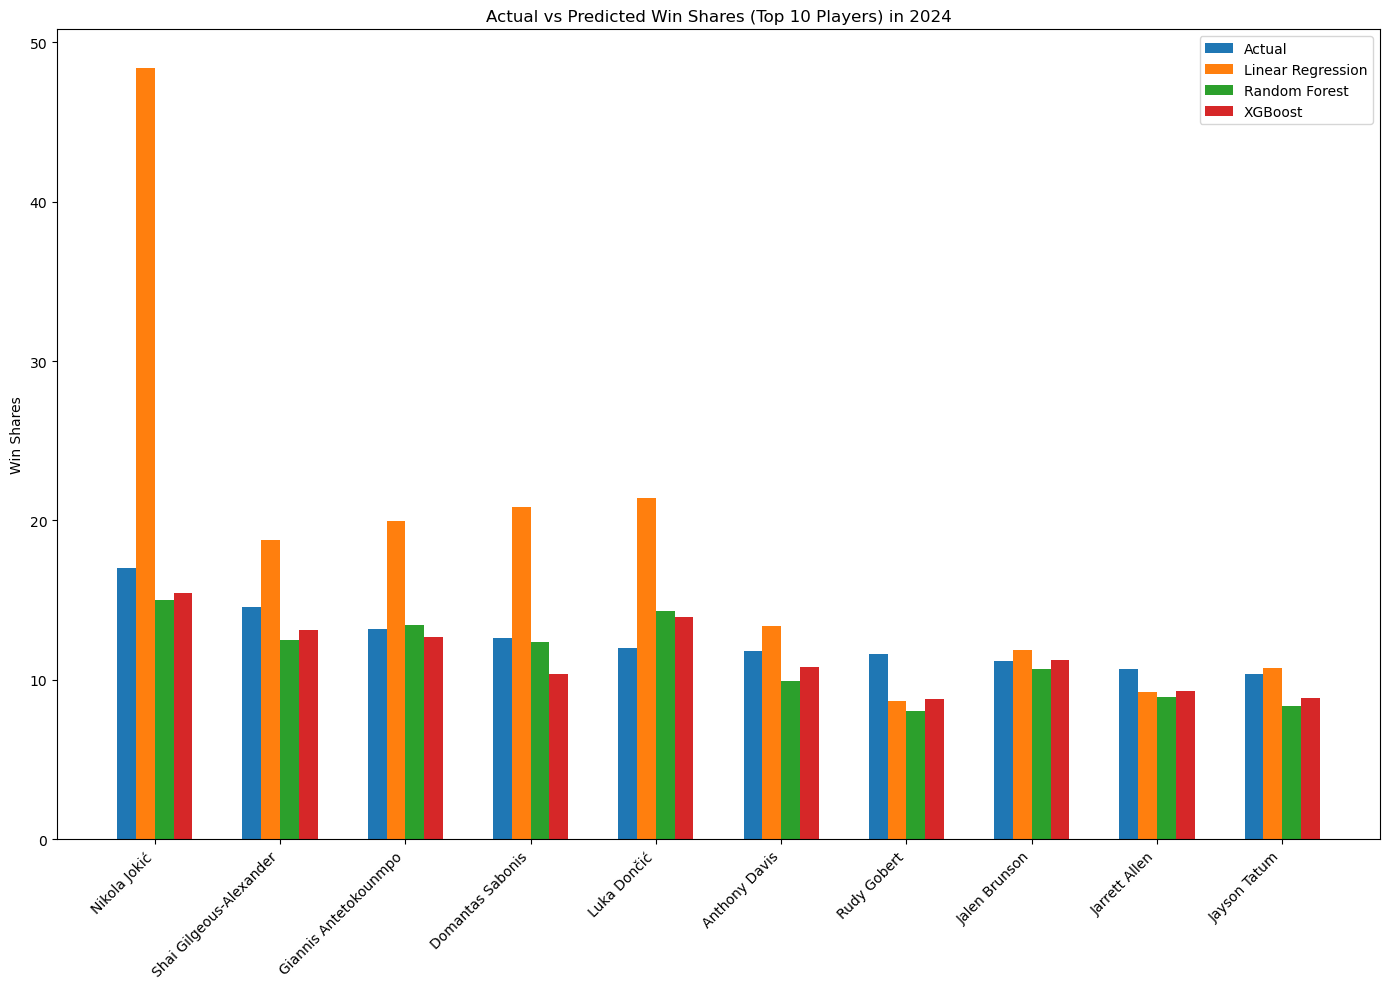

In [ ]:
temp_df = Cleaned_Nbacombined[Cleaned_Nbacombined['Year'] == 2024].copy()
temp_df = temp_df.reset_index(drop=True)


temp_df['Actual'] = y_test.values
temp_df["Linear Regression"] = preds["Linear Regression"]
temp_df["Random Forest"] = preds["Random Forest"]
temp_df["XGBoost"] = preds["XGBoost"]


top10 = temp_df.sort_values('Actual', ascending=False).head(10)
players = top10['Player']


model_names = ['Actual','Linear Regression', 'Random Forest', 'XGBoost']
bar_data = top10[model_names].values.T

x = np.arange(len(players))
width = 0.15


fig, ax = plt.subplots(figsize=(14, 10))

for i, model in enumerate(model_names):
     ax.bar(x + i * width - width*1.5, bar_data[i], width, label=model)

ax.set_xticks(x)
ax.set_xticklabels(players, rotation=45, ha="right")
ax.set_ylabel("Win Shares")
ax.set_title("Actual vs Predicted Win Shares (Top 10 Players) in 2024")
ax.legend()

plt.tight_layout()
plt.show()

From the top 10 players with the highest win shares, we can that XGboost and Random forest are the bstter options for our model. Lets plot residuals to see if there is any bias in our model.

### Linear Regression Residuals

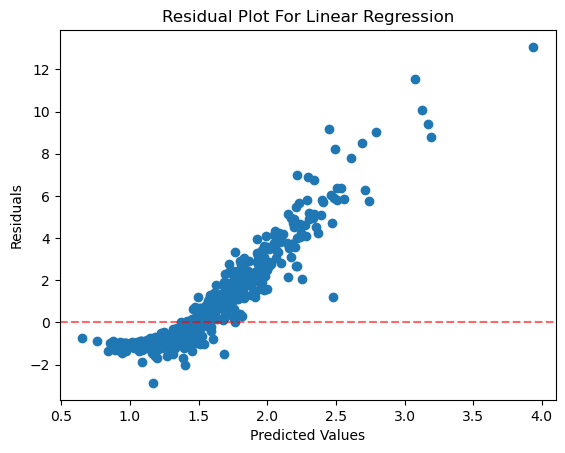

In [ ]:
ypredLR = LR_Model.predict(X_test)
residuals = y_test - ypredLR
plt.scatter(ypredLR, residuals)
plt.axhline(0, color='red', linestyle='--',alpha=0.6) 
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot For Linear Regression')    
plt.show()

### XGBoost Model Residuals

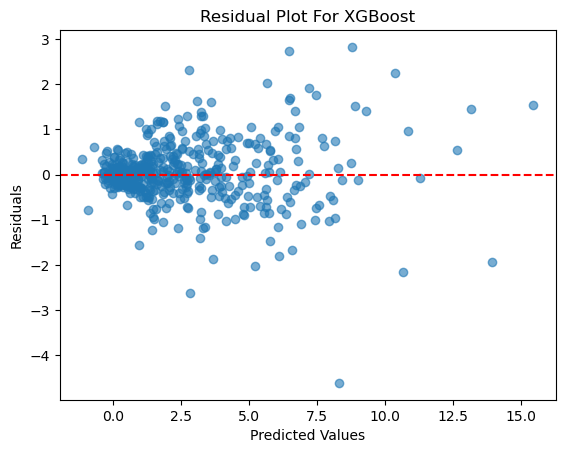

In [ ]:
y_test_array = y_test.values.ravel() 
ypredXGB = XGB_reg.predict(X_test)
residuals = y_test_array - ypredXGB
plt.scatter(ypredXGB, residuals,alpha = 0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot For XGBoost')
plt.show()

### Random Forest Residuals

Text(0.5, 1.0, 'Residual Plot For Random Forest')

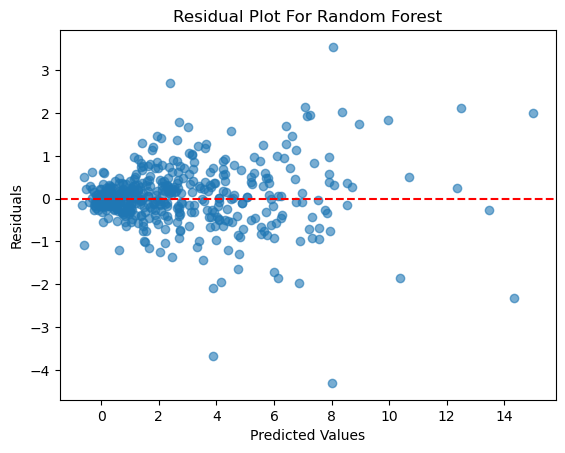

In [ ]:
y_test_array = y_test.values.ravel() 
ypredRF =best_rf_model.predict(X_test)
residuals = y_test_array - ypredRF
plt.scatter(ypredRF, residuals,alpha = 0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot For Random Forest')

The residual plot for the linear regression shows curvature, indicating that a linear regression model may not be the best fit for the data.
Both the residal plot of XGBmodel and RandomForest model are almost similar, But the R2 and RMSE score of the XGB model is better than the RandomForest model. So the final model to be chosen is XGB model.

In [ ]:
import joblib

In [ ]:
joblib.dump(XGB_reg, "best_xgboost_model.pkl")

['best_xgboost_model.pkl']